In [1]:
using HDF5, EzXML, Glob, Dates, Plots, Optim, LineSearches, LsqFit

datapath = "/Users/jjc/Documents/SSC/CSF Data/selected_recordings"
path = pwd();
savepath = "/Users/jjc/CSF/"
files = glob("*.hdf5", datapath);

# for filename in files

filename =  datapath*"/INF_20200909122333_INF2.hdf5"
# filename = datapath*"/INF_20190708150215_INF2.hdf5"
# filename = datapath*"/INF_20191010113919_INF2.hdf5"
# filename = datapath*"/INF_9CA2CCEC_E238_4CB0_99DC_78B94C06CAB9.hdf5"


fid = h5open(filename, "r")

# Get attributes outside of datasets/groups
recording_end_time = read_attribute(fid, "dataEndTime")
recording_start_time = read_attribute(fid, "dataStartTime")
dur = read_attribute(fid, "duration")
dur = split(dur[1], " ")
recording_duration = parse(Int64, dur[1])

# Begin handling data in XML string - some files do not have infusion test output
xml_obj = fid["aux/ICM+/icmtests"]
xml_data = read(xml_obj)
xml_string = String(xml_data[1])

data = parsexml(xml_string)
icm_data = root(data)
vars = elements(icm_data)

SingleAnalysis = firstelement(vars[2])
SingleAnalysis = elements(SingleAnalysis)
Variables = elements(SingleAnalysis[1])
Selections = elements(SingleAnalysis[2])
Parameters = elements(SingleAnalysis[3])
Results = elements(SingleAnalysis[4])

inf_rate = parse(Float64, Parameters[1]["Value"])

function parseXML(Parameters, Selections)
    
    selections = Dict{String, String}
    results = Dict{String, Float64}
    
    for i in 1:length(Selections)
        sel = elements(Selections[i])
        sel_name = Selections[i]["Name"]
        sel_st = sel[1]["StartTime"]
        sel_en = sel[1]["EndTime"]  

        sel_st = DateTime(sel_st, dateformat"dd/mm/yyyy HH:MM:SS")
        sel_en = DateTime(sel_en, dateformat"dd/mm/yyyy HH:MM:SS")

        selections =  merge!(selections, Dict(sel_name => [sel_st, sel_en]))
    end

    for i in 1:length(Results)
        res = elements(Results[i]);
        res_name = Results[i]["Name"]
        name_surrogate = split(res_name, " ");

        # Some parameters name have units e.g. [mmHg] but Dict field naming does not support strings with non-alphanumeric chars
        if isletter(name_surrogate[2][1])
            res_name = name_surrogate[1]*"_"*name_surrogate[2];
        else
            res_name = name_surrogate[1];
        end

        res_val = Results[i]["Value"]
        results =  merge!(results, Dict(res_name => parse(Float64, res_val)))
    end
    return results, selections
end

results, selections = parseXML(Parameters, Selections);

# This dereferencing is pain, there has to be a more elegant solution
t_series_ds = fid["summaries/minutes/"]
t_series = t_series_ds[:]

numsamples = length(t_series)

# Pre-allocate
ICP = zeros(numsamples)
AMP = zeros(numsamples)
timestamp = zeros(numsamples)
P0 = zeros(numsamples)
AMP_P = zeros(numsamples)

# Dereferencing named tuple...
for i in 1:numsamples
    ICP[i] = t_series[i].ICP
    AMP[i] = t_series[i].AMP
    timestamp[i] = t_series[i].datetime
    P0[i] = t_series[i].P0
    AMP_P[i] = t_series[i].AMP_P
end

start_time = DateTime(recording_start_time[1], dateformat"yyyy/mm/dd HH:MM:SS")
end_time = DateTime(recording_end_time[1], dateformat"yyyy/mm/dd HH:MM:SS")
infusion_start_frame = round(Int, (selections["Infusion"][1] - start_time).value / 10000) # 10,000 because /1,000 from ms -> s, and sampling every 10s (0.1Hz) 
infusion_end_frame = round(Int, (selections["Infusion"][2] - start_time).value / 10000)
plateau_start = round(Int, (selections["Plateau"][1] - start_time).value / 10000)
plateau_end= round(Int, (selections["Plateau"][2] - start_time).value / 10000)
rec_dur = end_time - start_time # in milliseconds
rec_dur_s = rec_dur.value / 1000

# Get parameters in legible forms - not neccessary, done for clarity
# Constants:
P_p  = results["ICP_plateau"]
I_inf = inf_rate;
P_b = results["ICP_baseline"]
T = [0:numsamples-1...] * 1/6

# Estimates
I_b = results["CSF_production"]
E = 0.0
# Because not all files have E saved
try
    E = results["Elasticity"]
catch
    global E = 0.11
end
P_0 = results["Pss"]
;

# println(P_0)
# # Print parameters from the file
# println("Iₐ = $I_b [mL/min]\n" * "E = $E [mL/mmHg]\n" * "P₀ = $P_0 [mmHg]\n")

# Optimization setup
# x[1] = I_b
# x[2] = E
# x[3] = P_0
# x0 = [I_b, E, P_0]

In [106]:
# Functions
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
delta(i) = maximum([0, i]) > 0 ? 1 : 0

# Model equation
function mfun(X, t)
    I_b = X[1]
    E = X[2]
    P_0 = X[3]
    It = I_b + I_inf
    ΔP = P_b - P_0
    y = It * ΔP / (I_b + (I_inf * exp(-E*It*t))) + P_0;
    return y
end

# Sum squared error function
function sqerror(X)
    err = 0.0        
    for i = 1:length(Pm)
        tᵢ = (i-1)/6 
        predᵢ = mfun(X,tᵢ)
        err += (Pm[i] - predᵢ)^2
    end
    δΔP = maximum([0.0, X[3]-P_b])
    δlb = delta.(lower.-X)
    δub = delta.(X.-upper)
    δ = vcat(δlb, δub, δΔP) # i = 1,⋯,q
    dist = vcat(lower.-X, X.-upper) # Distances between the constraint and the current value
    h = abs.(dist) # i = q+1,⋯,m
    d = vcat(δ, h)
    penalty = sum(C.*d.^κ)
    return err + penalty
end

# Plotting
function plot_model(I_b, E, P_0)

    println("Estimated parameters:\nIₐ = $I_b [mL/min]\n"*"E = $E [mmHg/mL]\n"*"P₀ = $P_0 [mmHg]\n")

    P_m = zeros(numsamples)
    P_m .+= P_b
    P_model = zeros(numsamples)
    ICPm = zeros(infusion_end_frame-infusion_start_frame)

    for i = infusion_start_frame:infusion_end_frame
        tᵢ = (i-infusion_start_frame)/6
        It = I_b + I_inf
        ΔP = P_b - P_0
        y = It * ΔP / (I_b + (I_inf * exp(-E*It*tᵢ))) + P_0;
        P_model[i] = y
    end

    ICPm = P_model[infusion_start_frame:infusion_end_frame]
    P_m[infusion_start_frame:infusion_end_frame] = ICPm
    P_m[infusion_end_frame+1:end] .= ICPm[end]
    # P_m[infusion_end_frame+1:end] .= P_p

    # plateau_end=numsamples
    vline([infusion_start_frame], background=:transparent, legend=:outertopright, linestyle=:dash, linecolor=:white, linewidth=1, label="Start of infusion")
    plot!(g0[1:plateau_end], linewidth=2, alpha=0.8, linecolor=:violet, label="Moving average") # Plot moving average
    plot!(ICP[1:plateau_end], linecolor=:cadetblue, linewidth=2, label="Measured", alpha=0.7) # Plot ICP from beginning until end of plateau
    # Plot model prediction from beginning until end of plateau
    plot!(P_m[1:plateau_end], linecolor=:orange, linewidth=2, linestyle=:dash, xlims=[1, plateau_end], ylims=[0,40], 
    xlabel="Time [min]", ylabel="ICP [mmHg]",xticks = ([0:30:plateau_end;], [0:30:plateau_end;]./10),
    label = "Model")

end;

Estimated parameters:
Iₐ = 0.2794553246026013 [mL/min]
E = 0.12042172924170888 [mmHg/mL]
P₀ = 11.661920638157946 [mmHg]



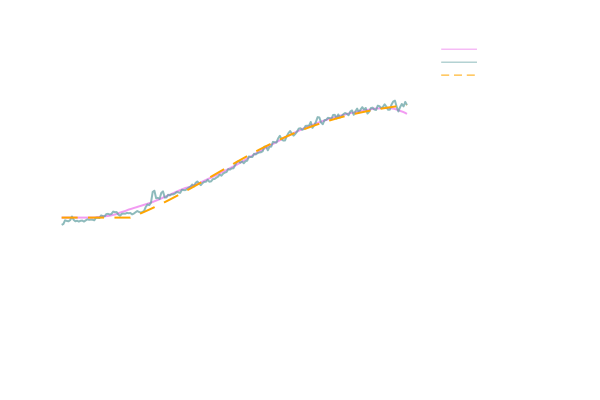

In [102]:
Pm = ICP[infusion_start_frame:infusion_end_frame] # ICP data truncated only to the period of infusion
# Pm = ICP[infusion_start_frame:plateau_start] # ICP data truncated only to the period of the slope before  baseline

X = I_b, E, P_0

# Moving average = smoothed trace
dsampf = 40 # Downsampling factor (no. of frames in a window for calculation of the mean)
gg = moving_average(ICP, dsampf)
g0 = zeros(length(ICP))
g0 .+= P_b
g0[Int(dsampf/2):Int(dsampf/2)+length(gg)-1] = gg
g0[Int(dsampf/2)+length(gg):end] .= P_p

Pm_ave = g0[infusion_start_frame:infusion_end_frame]
# Pm = Pm_ave

x0 = [0.3, 0.1, 3] # Starting point
lower = [0.1, 0.01, -10.0]
upper = [1.0, 1.0, 50.0]

C = 10^3#Cᵢ
κ = 1

res = optimize(sqerror, x0, LBFGS())
I_b, E, P_0 = Optim.minimizer(res)
R = Dict("LBFGS" => Optim.minimum(res))
# println("P₀ = $P_0\nPᵦ = $P_b\nΔP = $(P_b-P_0)\n") 
plot_model(I_b, E, P_0)

In [ ]:
length(Pm_ave)

Estimated parameters:
Iₐ = 0.2794553242189261 [mL/min]
E = 0.12042172920878355 [mmHg/mL]
P₀ = 11.661920641524304 [mmHg]



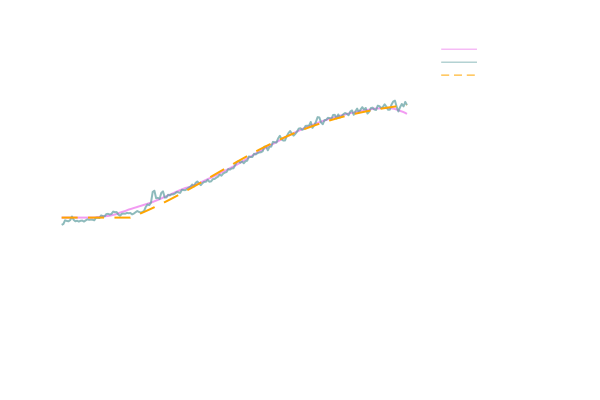

In [103]:
# Define gradient
function g!(G, X)
    I_b = X[1]
    E = X[2]
    P_0 = X[3]

    t = 1/6
    
    It = I_inf + I_b
    ΔP = P_b - P_0
    Q = I_inf * exp(E*t*It)

    # G[1] = ΔP/(Q+I_b)-(ΔP*It*(1-E*I_inf*t*exp(-E*t*It)))/(Q+I_b)^2
    # G[2] = (It^2*ΔP*t*Q)/(I_b*exp(It*t*E)+I_inf)^2
    # G[3] = 1-It/(Q+I_b)

    G[1] = -(I_inf*(P_b-P_0)*exp(E*(I_b+I_inf))*(exp(E*(I_b+I_inf))-E*I_b-E*I_inf-1))/(I_b*exp(E*(I_b+I_inf))+I_inf)^2
    G[2] = (I_inf*(I_inf+I_b)^2*(P_b-P_0)*exp((I_inf+I_b)*E))/(I_b*exp((I_inf+I_b)*E)+I_inf)^2
    G[3] = 1-(I_inf+I_b)/(I_inf*exp(-E*(I_inf+I_b))+I_b)
end

# Define Hessian
function h!(H, X)
    I_b = X[1]
    E = X[2]
    P_0 = X[3]


    # It = I_inf + I_b # Total rate of CSF volume increase
    # ΔP = P_b - P_0 # Pressure difference between ICP at baseline and reference pressure
    # Q = exp(E*t*It) # For neatness
    # t = 1/6
    # Time-dependent - probably should use without time
    # H[1, 1] = (I_inf*ΔP*Q*(2*exp(2*E*t*It)+(-E^2*t^2*I_b^2+(-E^2*I_inf*t^2-2*E*t)*I_b-4*E*I_inf*t-2)*Q+E^2*I_inf*t^2*I_b+E^2*I_inf^2*t^2+2*E*I_inf*t))/(I_b*Q+I_inf)^3
    # H[1, 2] = -(I_inf*It*ΔP*t*exp(It*t*E)*(((I_b*It^2)*t*E+2*I_inf)*exp(It*t*E)+(-I_inf^2-I_b*I_inf)*t*E-2*I_inf))/(I_b*exp(It*t*E)+I_inf)^3
    # H[1, 3] = (I_inf*exp(E*It*t)*(exp(E*It*t)+(-E*I_inf-E*I_b)*t-1))/(I_b*exp(E*It*t)+I_inf)^2
    # H[2, 1] = -(I_inf*ΔP*t*It*Q*((E*t*I_b^2+E*I_inf*t*I_b+2*I_inf)*Q-E*I_inf*t*I_b-E*I_inf^2*t-2*I_inf))/(I_b*Q+I_inf)^3
    # H[2, 2] = -(I_inf*It^3*ΔP*t^2*exp(It*t*E)*(I_b*exp(It*t*E)-I_inf))/(I_b*exp(It*t*E)+I_inf)^3
    # H[2, 3] = -(I_inf*It^2*t*exp(E*It*t))/(I_b*exp(E*It*t)+I_inf)^2
    # H[3, 1] = (I_inf*Q*(Q-E*t*I_b-E*I_inf*t-1))/(I_b*Q+I_inf)^2
    # H[3, 2] = -(I_inf*It^2*t*exp(It*t*E))/(I_b*exp(It*t*E)+I_inf)^2
    # H[3, 3] = 0 # ∂f/∂P_0 is linear, so ∂²f/∂P_0² = 0


    H[1, 1] = (I_inf*(P_b-P_0)*exp(E*(I_b+I_inf))*(2*exp(2*E*(I_b+I_inf))+(-E^2*I_b^2+(-E^2*I_inf-2*E)*I_b-4*E*I_inf-2)*exp(E*(I_b+I_inf))+E^2*I_inf*I_b+E^2*I_inf^2+2*E*I_inf))/(I_b*exp(E*(I_b+I_inf))+I_inf)^3
    H[1, 2] = -(I_inf*(I_inf+I_b)*(P_b-P_0)*exp((I_inf+I_b)*E)*(((I_b*I_inf+I_b^2)*E+2*I_inf)*exp((I_inf+I_b)*E)+(-I_inf^2-I_b*I_inf)*E-2*I_inf))/(I_b*exp((I_inf+I_b)*E)+I_inf)^3
    H[1, 3] = (I_inf*exp(E*(I_inf+I_b))*(exp(E*(I_inf+I_b))-E*I_inf-E*I_b-1))/(I_b*exp(E*(I_inf+I_b))+I_inf)^2
    H[2, 1] = -(I_inf*(P_b-P_0)*(I_b+I_inf)*exp(E*(I_b+I_inf))*((E*I_b^2+E*I_inf*I_b+2*I_inf)*exp(E*(I_b+I_inf))-E*I_inf*I_b-E*I_inf^2-2*I_inf))/(I_b*exp(E*(I_b+I_inf))+I_inf)^3
    H[2, 2] = -(I_inf*(I_inf+I_b)^3*(P_b-P_0)*exp((I_inf+I_b)*E)*(I_b*exp((I_inf+I_b)*E)-I_inf))/(I_b*exp((I_inf+I_b)*E)+I_inf)^3
    H[2, 3] = -(I_inf*(I_inf+I_b)^2*exp(E*(I_inf+I_b)))/(I_b*exp(E*(I_inf+I_b))+I_inf)^2
    H[3, 1] = (I_inf*exp(E*(I_b+I_inf))*(exp(E*(I_b+I_inf))-E*I_b-E*I_inf-1))/(I_b*exp(E*(I_b+I_inf))+I_inf)^2
    H[3, 2] = -(I_inf*(I_inf+I_b)^2*exp((I_inf+I_b)*E))/(I_b*exp((I_inf+I_b)*E)+I_inf)^2
    H[3, 3] = 0 # ∂f/∂P_0 is linear, so ∂²f/∂P_0² = 0

end

# Pm = Pm_ave
mysolver = NewtonTrustRegion(;  initial_delta = 1.0,
                                delta_hat = 100.0,
                                eta = 0.1,
                                rho_lower = 0.25,
                                rho_upper = 0.75)


x0 = [0.3, 0.1, 5] # Starting point
r = 10^2
κ = 1 # should be 1 or even
res = Optim.optimize(sqerror, x0, mysolver)
I_b, E, P_0 = Optim.minimizer(res)
R = merge!(R, Dict("NewtonTrustRegion"=>Optim.minimum(res)))
plot_model(I_b, E, P_0)

In [ ]:

# Levenberg-Marquardt algorithm

# p[1] = I_b
# p[2] = E
# p[3] = P_0
# p = [I_b, E, P_0]
nsamps = numsamples

t = T
@. model(t, p) = ((I_inf + p[1]) * (P_b - p[3]) / (p[1] + (I_inf * exp(-p[2]*(I_inf + I_b)*t)))) + p[3]


p0 = [0.35, 0.2, 2]

st = infusion_start_frame
en = plateau_end

xdata = 0:numsamples-1
# xdata = st:en
# xdata *= 1/6
ydata = ICP 

fit = curve_fit(model, t[st:en], ICP[st:en], p0)


sigma = stderror(fit)
margin_of_error = margin_error(fit, 0.05)
confidence_inter = confidence_interval(fit, 0.05)
I_b, E, P_0 = fit.param

G = zeros(numsamples)
for i = 1:numsamples
    It = I_b + I_inf
    ΔP = P_b - P_0
    y = It * ΔP / (I_b + (I_inf * exp(-E*It*t[i]))) + P_0;
    G[i] = y
end

println("Ib = $I_b\n E = $E\n P0 = $P_0")

plot([G[1:en],ICP[1:en]], background=:transparent, linecolor=[:orange :cadetblue], linestyle=[:dash :solid], linewidth=2,
xlabel="Time [min]", ylabel="ICP [mmHg]",xticks = ([0:30:numsamples;], [0:30:numsamples;]./10), legend=:outertopright)



In [105]:
# TODO: Implement Lagrange Multiplier Method/Augmented Lagrangian Method/Penalty Method

